In [1]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from array import array

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.13/02


In [2]:
fpath = {}
tree = {}
process = {}
process_short = {}

fpath['m500ctau1000'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-1000mm.root'
# fpath['m500ctau30'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-30mm.root'
# fpath['QCD300to500'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_QCD_HT300to500.root'

legend = {'m500ctau1000', 'Mass = 500 GeV, ctau = 1 m'}

for k,v in fpath.iteritems():
    print k, v
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["jetPt"]
    print a[:-1][0]

m500ctau1000 /home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-1000mm.root
[527.2854  412.97708]


In [4]:
T = tree['m500ctau1000']
print("number of events:"+str(len(T)))
# T30 = tree['m500ctau30']
# QCD = tree['QCD300to500']

number of events:10000


# Check PV

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


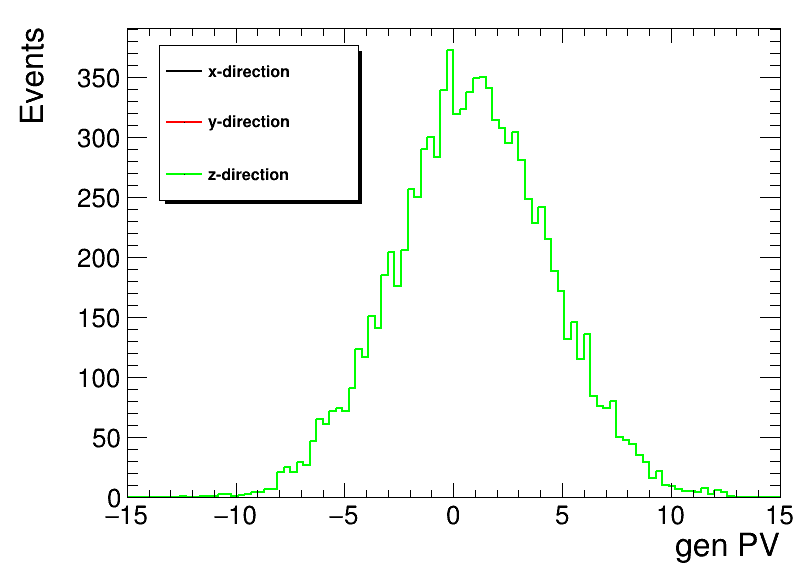

In [21]:
genX = np.array([x for x in T['genVertexX']])
llp_prod_x = np.array([x[0] for x in T['gLLP_prod_vertex_x']])
pvX = np.array(T['pvX'])
genY = np.array([x for x in T['genVertexY']])
llp_prod_y = np.array([x[0] for x in T['gLLP_prod_vertex_y']])
pvY = np.array(T['pvY'])
genZ= np.array([x for x in T['genVertexZ']])

llp_prod_z = np.array([x[0] for x in T['gLLP_prod_vertex_z']])
pvZ = np.array(T['pvZ'])

c = rt.TCanvas('c','c', 800, 600)
h = {}

h['pvX'] = create_TH1D( genX, axis_title=['gen PV', 'Events'], name='pvX', binning=[100,-0.01,0.01])
h['pvX'].SetLineColor(1)
h['pvY'] = create_TH1D( genY, axis_title=['gen PV', 'Events'], name='pvY', binning=[100,-0.01,0.01])
h['pvY'].SetLineColor(2)
h['pvZ'] = create_TH1D( genZ, axis_title=['gen PV', 'Events'], name='pvZ', binning=[100,-15,15])
h['pvZ'].SetLineColor(3)

# h['pvZ'].DrawNormalized('')
# h['pvY'].DrawNormalized('same')
h['pvZ'].Draw('')
leg = rt.TLegend(0.2,0.65,0.45,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
leg.AddEntry(h['pvX'],"x-direction")
leg.AddEntry(h['pvY'],"y-direction")
leg.AddEntry(h['pvZ'],"z-direction")
leg.Draw()

c.Draw()
# c.SaveAs("pvX.pdf")

In [22]:
#get max jet pt per event, also jet[0]
max_jet_pt = np.array([np.max(x) if len(x) else -1 for x in T['jetPt']])
max_jet_ecal_energy = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E']])
max_jet_ecal_energy1 = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E_Ecut1']])
max_jet_ecal_energy2 = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E_Ecut2']])

assert(len(max_jet_ecal_energy) == len(max_jet_pt))
print(len(max_jet_ecal_energy))
print(len(max_jet_pt[max_jet_ecal_energy<50]))
# print max_jet_pt

10000
3562


# Check matching between genParticles with genJets

11667
0.919059955588453


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file match_efficiency_genJets.pdf has been created


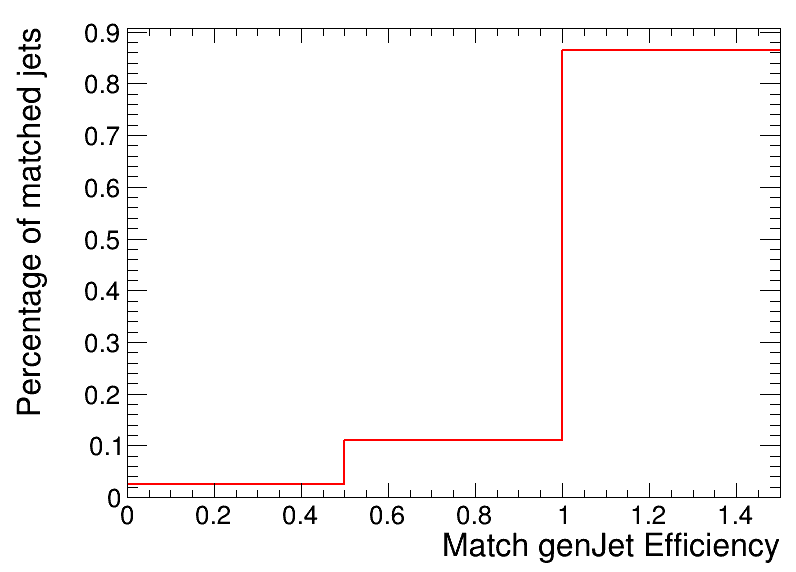

In [23]:
gLLP_daughter_match_genJet_index=T['gLLP_daughter_match_genJet_index']
# gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
daughter_eta =  T['gLLP_daughter_eta']
gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']
eventNum = T['eventNum']
# number of matched/barrel jets for each LLP
# matched_jets.shape = (events,2)
matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_genJet_index == 666))
matched_genjets_perllp = np.column_stack((np.count_nonzero(matched_jets[:,:2],axis=1),np.count_nonzero(matched_jets[:,2:],axis=1)))
# print(matched_genjets_perllp.shape)
LLP_daughter_barrel = np.logical_not( gLLP_daughter_travel_time == -666) #shape: (events, 4)
barrel_daughter_perllp = np.column_stack((np.count_nonzero(LLP_daughter_barrel[:,:2],axis=1),np.count_nonzero(LLP_daughter_barrel[:,2:],axis=1)))
# now both matched_jets_perllp and barrel_jets_perllp are flattened with shape: (LLP#, )
# gLLP_decay_radius and match_efficiency also have shape (LLP#,)
matched_genjets_perllp = matched_genjets_perllp[barrel_daughter_perllp>0]
barrel_daughter_perllp = barrel_daughter_perllp [barrel_daughter_perllp > 0]
assert(matched_genjets_perllp.shape == barrel_daughter_perllp.shape)


match_genjet_efficiency = np.divide(1.0* matched_genjets_perllp , barrel_daughter_perllp) #match efficiency for each LLP
#     print(np.count_nonzero(barrel_jets_perevent),np.count_nonzero(matched_jets_perevent))


c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.2,0.65,0.55,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
h['match_efficiency'] = create_TH1D( match_genjet_efficiency, axis_title=['Match genJet Efficiency', 'Percentage of matched jets'], name='match_efficiency', binning=[3,0,1.5])
h['match_efficiency'].SetLineColor(2)

# c.SetLogy()
print(np.count_nonzero(match_genjet_efficiency==1))
print(np.sum(match_genjet_efficiency)/np.size(match_genjet_efficiency))

h['match_efficiency'].DrawNormalized()
# leg.Draw()
c.Draw()
c.SaveAs("match_efficiency_genJets.pdf")

# Matching between gen jets and reco jets

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file match_efficiency_genJets_reco.pdf has been created


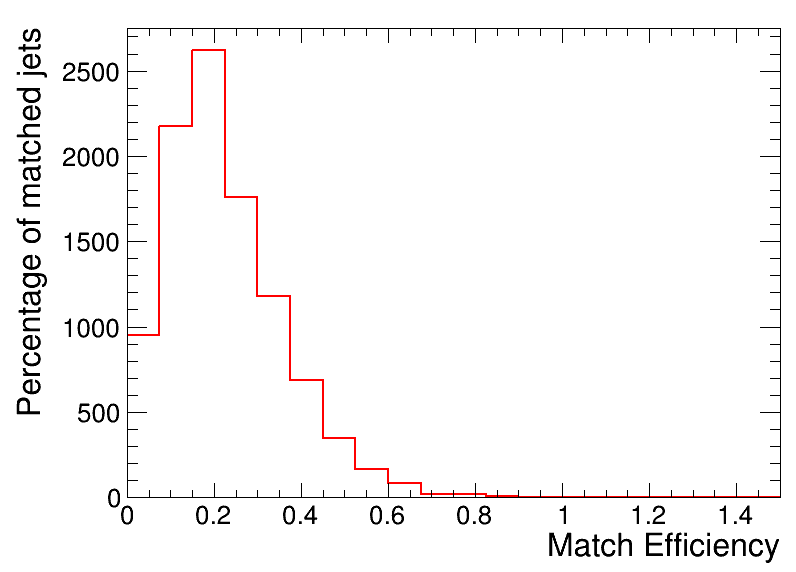

In [24]:
genJet_match_jet_index = np.array(T['genJet_match_jet_index'])
nGenJets = np.array(T['nGenJets'])
min_deltar=T['genJet_min_delta_r_match_jet']
matchedNum = []
eventNum = T['eventNum']
for i in range(len(T['genJet_match_jet_index'])):
    genJets_index = T['genJet_match_jet_index'][i]
    matched = np.logical_not( genJets_index == 666)
    matched_jets = np.count_nonzero(matched)
    unmatched_jets = np.count_nonzero(matched==0)
    matchedNum.append(matched_jets*1.0/nGenJets[i])
    assert(matched_jets+unmatched_jets == nGenJets[i])
    
    
    
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.2,0.65,0.55,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
h['match_efficiency'] = create_TH1D( matchedNum, axis_title=['Match Efficiency', 'Percentage of matched jets'], name='match_efficiency', binning=[20,0,1.5])
h['match_efficiency'].SetLineColor(2)

# c.SetLogy()
# h['match_efficiency2'].GetYaxis().SetRangeUser(0,1.0)

h['match_efficiency'].Draw()
# leg.Draw()
c.Draw()
c.SaveAs("match_efficiency_genJets_reco.pdf")

# Matched Jets and how they change with LLP decay radius

In [34]:
# Create 2d numpy array matched-jets vs. LLP decay radius
# matched_jet = np.array([4-np.count_nonzero(x == 666) if len(x) else -1 for x in T['gLLP_daughter_match_jet_index']])

match_efficiency_llp_dict = {}
gLLP_decay_radius_dict = {}
gLLP_decay_distance_dict = {}
gLLP_decay_z_dict = {}
matched_jets_perllp_dict = {}
barrel_jets_perllp_dict = {}
loosematched_jets_perllp_dict = {}
hcalmatched_jets_perllp_dict = {}
hcalloosematched_jets_perllp_dict = {}
match_efficiency_event = {}
for k,T in tree.items():
    gLLP_decay_radius = np.sqrt(np.square(T['gLLP_decay_vertex_x']-T['gLLP_prod_vertex_x'])+np.square(T['gLLP_decay_vertex_y']-T['gLLP_prod_vertex_y'])) # (events, 2) 2LLP
    gLLP_decay_z = np.absolute(T['gLLP_decay_vertex_z']-T['gLLP_prod_vertex_z'])
    gLLP_decay_distance = np.sqrt(np.square(T['gLLP_decay_vertex_x']-T['gLLP_prod_vertex_x'])+np.square(T['gLLP_decay_vertex_y']-T['gLLP_prod_vertex_y'])+np.square(T['gLLP_decay_vertex_z']-T['gLLP_prod_vertex_z']))
# gLLP_decay_radius = np.reshape(gLLP_decay_radius,(-1,1)) # flatten (2*events, 1)
#     gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
    gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
    gLLP_daughter_match_jet_index_hcal = T['gLLP_daughter_match_jet_index_hcal']
    gLLP_daughter_match_jet_index_loose = T['gLLP_daughter_match_jet_index_loose']
    gLLP_daughter_match_jet_index_hcalloose = T['gLLP_daughter_match_jet_index_hcal_loose']

    gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']
    eventNum = T['eventNum']
    # number of matched/barrel jets for each LLP
    # matched_jets.shape = (events,2)

    matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index == 666))
    matched_jets_perllp = np.column_stack((np.count_nonzero(matched_jets[:,:2],axis=1),np.count_nonzero(matched_jets[:,2:],axis=1)))
    
    loosematched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index_loose == 666))
    loosematched_jets_perllp = np.column_stack((np.count_nonzero(loosematched_jets[:,:2],axis=1),np.count_nonzero(loosematched_jets[:,2:],axis=1)))

    hcalmatched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index_hcal == 666))
    hcalmatched_jets_perllp = np.column_stack((np.count_nonzero(hcalmatched_jets[:,:2],axis=1),np.count_nonzero(hcalmatched_jets[:,2:],axis=1)))

    hcalloosematched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index_hcalloose == 666))
    hcalloosematched_jets_perllp = np.column_stack((np.count_nonzero(hcalloosematched_jets[:,:2],axis=1),np.count_nonzero(hcalloosematched_jets[:,2:],axis=1)))

    matched_jets_perevent = np.count_nonzero(matched_jets,axis=1)
    # barrel_jets.shape = (events,2)
    LLP_daughter_barrel = np.logical_not( gLLP_daughter_travel_time == -666) #shape: (events, 4)
    barrel_jets_perllp = np.column_stack((np.count_nonzero(LLP_daughter_barrel[:,:2],axis=1),np.count_nonzero(LLP_daughter_barrel[:,2:],axis=1)))
    barrel_jets_perevent = np.count_nonzero(LLP_daughter_barrel,axis=1)

    # now both matched_jets_perllp and barrel_jets_perllp are flattened with shape: (LLP#, )
    # gLLP_decay_radius and match_efficiency also have shape (LLP#,)
    
    print("Fraction of barrel jets: "+str(1.0*np.count_nonzero(LLP_daughter_barrel)/np.size(LLP_daughter_barrel)))
    print("Fraction of endcap jets: "+str(1.0*np.count_nonzero(LLP_daughter_barrel==0)/np.size(LLP_daughter_barrel)))
    print("Fraction of barrel-barrel: "+str(1.0*np.count_nonzero(barrel_jets_perllp==2)/np.size(barrel_jets_perllp)))
    print("Fraction of barrel-endcap: "+str(1.0*np.count_nonzero(barrel_jets_perllp==1)/np.size(barrel_jets_perllp)))
    print("Fraction of endcap-endcap: "+str(1.0*np.count_nonzero(barrel_jets_perllp==0)/np.size(barrel_jets_perllp)))
    assert (np.count_nonzero(barrel_jets_perllp==2)+np.count_nonzero(barrel_jets_perllp==1)+np.count_nonzero(barrel_jets_perllp==0)==np.size(barrel_jets_perllp))
    assert(np.count_nonzero(LLP_daughter_barrel)+np.count_nonzero(LLP_daughter_barrel==0)==np.size(LLP_daughter_barrel))
    
    #2D histograms
    hcalloosematched_jets_perllp = hcalloosematched_jets_perllp.flatten('F')
    loosematched_jets_perllp = loosematched_jets_perllp.flatten('F')
    hcalmatched_jets_perllp = hcalmatched_jets_perllp.flatten('F')
    barrel_jets_perllp = barrel_jets_perllp.flatten('F')
    matched_jets_perllp = matched_jets_perllp.flatten('F')
    gLLP_decay_radius = gLLP_decay_radius.flatten('F')
    gLLP_decay_z = gLLP_decay_z.flatten('F')
    gLLP_decay_distance = gLLP_decay_distance.flatten('F')

    # get rid of the 0 denominators
    hcalloosematched_jets_perllp = hcalloosematched_jets_perllp[barrel_jets_perllp>0]
    loosematched_jets_perllp = loosematched_jets_perllp[barrel_jets_perllp>0]
    hcalmatched_jets_perllp = hcalmatched_jets_perllp[barrel_jets_perllp > 0]
    matched_jets_perllp = matched_jets_perllp[barrel_jets_perllp>0]
    gLLP_decay_radius = gLLP_decay_radius[barrel_jets_perllp > 0] #llp decay radius of llp with at least one barrel
    gLLP_decay_z = gLLP_decay_z[barrel_jets_perllp > 0] #llp decay radius of llp with at least one barrel
    gLLP_decay_distance = gLLP_decay_distance[barrel_jets_perllp > 0] #llp decay radius of llp with at least one barrel
    barrel_jets_perllp = barrel_jets_perllp [barrel_jets_perllp > 0]
    assert(matched_jets_perllp.shape == gLLP_decay_radius.shape == barrel_jets_perllp.shape)
    
    
    # add to dictionary
    barrel_jets_perllp_dict[k] = barrel_jets_perllp
    matched_jets_perllp_dict[k] = matched_jets_perllp
    hcalmatched_jets_perllp_dict[k] = hcalmatched_jets_perllp
    loosematched_jets_perllp_dict[k] = loosematched_jets_perllp
    hcalloosematched_jets_perllp_dict[k] = hcalloosematched_jets_perllp
    match_efficiency_llp_dict[k] = np.divide(1.0* matched_jets_perllp , barrel_jets_perllp) #match efficiency for each LLP
    gLLP_decay_radius_dict[k] = gLLP_decay_radius
    gLLP_decay_z_dict[k] = gLLP_decay_z
    gLLP_decay_distance_dict[k] = gLLP_decay_distance
    
    ## per event
    eventNum = eventNum [barrel_jets_perevent > 0]
    matched_jets_perevent = matched_jets_perevent[barrel_jets_perevent>0]
    barrel_jets_perevent = barrel_jets_perevent [barrel_jets_perevent>0]
    eventNum = eventNum [np.logical_and(matched_jets_perevent==0 , barrel_jets_perevent ==4) ] #print event numbers
   
    
    
    assert(barrel_jets_perevent.shape == matched_jets_perevent.shape)
    match_efficiency_event[k] = np.divide(1.0* matched_jets_perevent , barrel_jets_perevent) #match efficiency for each LLP
    print('mean matching efficiency per event: '+ str(np.mean(match_efficiency_event[k])))
    print('mean matching efficiency per llp: '+ str(np.mean(match_efficiency_llp_dict[k])))



Fraction of barrel jets: 0.5905
Fraction of endcap jets: 0.4095
Fraction of barrel-barrel: 0.5055
Fraction of barrel-endcap: 0.17
Fraction of endcap-endcap: 0.3245
mean matching efficiency per event: 0.8518634721429931
mean matching efficiency per llp: 0.8493338267949667


# Plot matched jet efficiency vs LLP decay radius

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../plots/llp_decay_radius.pdf has been created


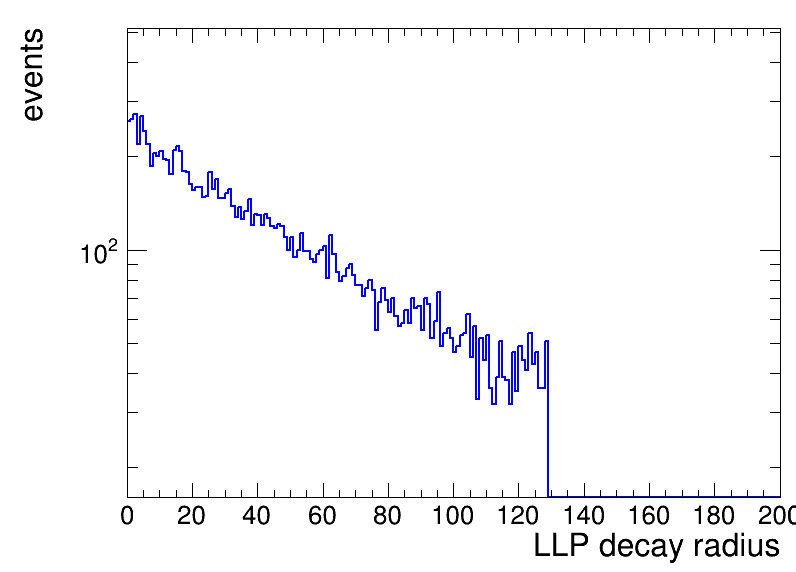

In [39]:
# LLP decay radius of the matched jets
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['llp_decayR'] = create_TH1D(gLLP_decay_radius_dict['m500ctau1000'], axis_title=['LLP decay radius', 'events'], name='llp_decayR', binning=[200,0,200])
h['llp_decayR'].SetLineColor(4)
c.SetLogy()
h['llp_decayR'].Draw()
c.Draw()
c.SaveAs("../plots/llp_decay_radius.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficien

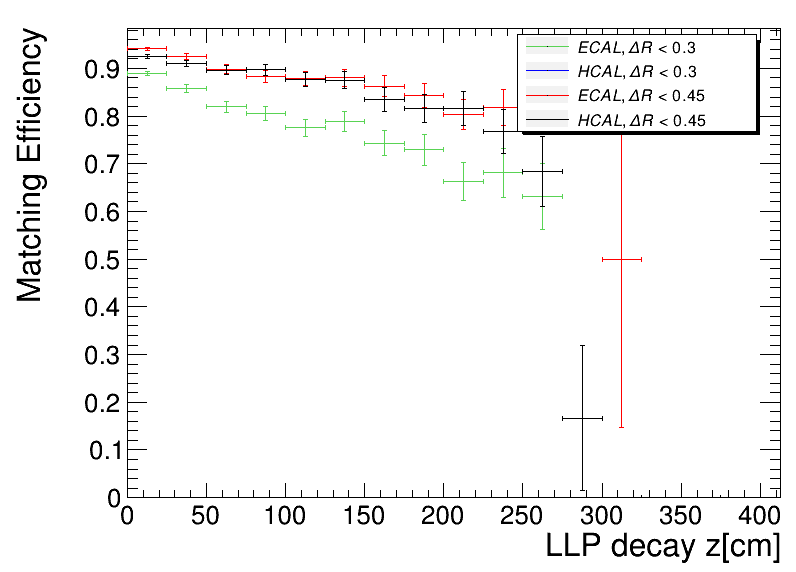

In [41]:
c = rt.TCanvas('c1','c1', 800, 600)
leg = rt.TLegend(0.65,0.77,0.95,0.94)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
# # Create 2d numpy array matched-jets vs. LLP decay radius
efficiency_plot= []

h = {}
pEff = []
xaxis = gLLP_decay_z_dict['m500ctau1000']
xaxis_title = 'LLP decay z[cm]'
k = 'm500ctau1000'
hm = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = matched_jets_perllp_dict[k])
hb = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = barrel_jets_perllp_dict[k])
pEff_ecal = rt.TEfficiency(hm,hb)

hmh = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = hcalmatched_jets_perllp_dict[k])
hbh = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = barrel_jets_perllp_dict[k])
pEff_hcal = rt.TEfficiency(hmh,hbh)

hml = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = loosematched_jets_perllp_dict[k])
hbl = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = barrel_jets_perllp_dict[k])
pEff_loose = rt.TEfficiency(hml,hbl)

hmhl = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = hcalloosematched_jets_perllp_dict[k])
hbhl = create_TH1D(xaxis, axis_title = [xaxis_title,'Matching Efficiency'], binning=[80,0,2000],weights = barrel_jets_perllp_dict[k])
pEff_hcalloose = rt.TEfficiency(hmhl,hbhl)

leg.AddEntry(pEff_ecal,"ECAL,\\Delta R<0.3")
leg.AddEntry(pEff_hcal,"HCAL,\\Delta R<0.3")
leg.AddEntry(pEff_loose,"ECAL,\\Delta R<0.45")
leg.AddEntry(pEff_hcalloose,"HCAL,\\Delta R<0.45")

# pEff_ecal.SetMarkerStyle(4)
# pEff_loose.SetMarkerStyle(4)
# pEff_hcalloose.SetMarkerStyle(26)
# pEff_hcal.SetMarkerStyle(26)

pEff_hcalloose.SetLineColor(1)
pEff_loose.SetLineColor(2)
pEff_ecal.SetLineColor(8)
pEff_hcal.SetLineColor(4)
pEff_ecal.Draw()
# pEff_hcal.Draw('same')
pEff_loose.Draw('same')
pEff_hcalloose.Draw('same')

leg.Draw()
c.Draw()
# pEff_ecal.GetPaintedGraph().GetYaxis().SetRangeUser(0.5,1.1)
# pEff_ecal.GetPaintedGraph().GetXaxis().SetRangeUser(0,300)

c.Update()
c.SaveAs("../plots/efficiency_compare_llpz.pdf")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TCanvas::Print>: pdf file ../plots/matchefficiency_2dllpz_llpradius_m500ctau1000.pdf has been created


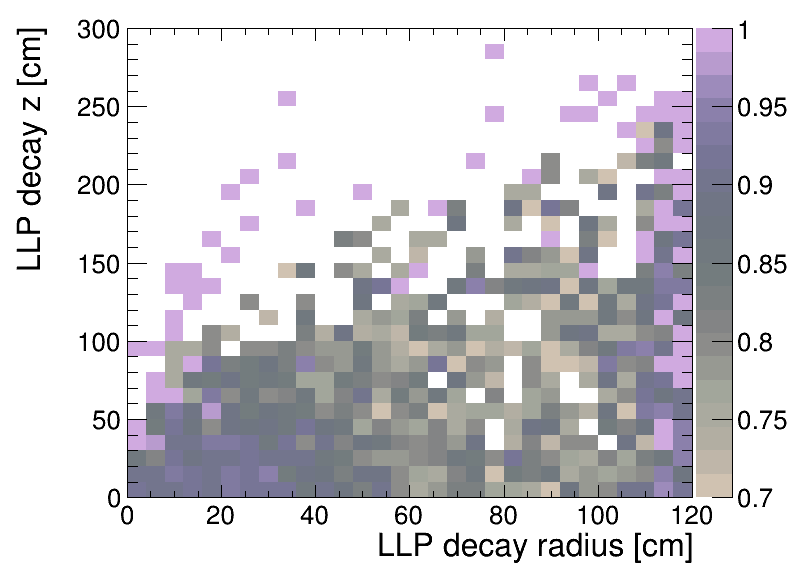

In [47]:
c = rt.TCanvas('c1','c1', 800, 600)
pEff = {}
for k, T in tree.items():
    binnings = [30,0,120,30,0,300]
    np.column_stack((gLLP_decay_radius_dict[k],gLLP_decay_z_dict[k]))
    hm = create_TH2D(np.column_stack((gLLP_decay_radius_dict[k],gLLP_decay_z_dict[k])), axis_title = ['LLP decay radius [cm]','LLP decay z [cm]','Matching Efficiency'], binning=binnings,weights = matched_jets_perllp_dict[k])
    hb = create_TH2D(np.column_stack((gLLP_decay_radius_dict[k],gLLP_decay_z_dict[k])), axis_title = ['LLP decay radius [cm]','LLP decay z [cm]','Matching Efficiency'], binning=binnings,weights = barrel_jets_perllp_dict[k])
    pEff[k] = rt.TEfficiency(hm,hb)

rt.gStyle.SetPalette(92)
pEff[k].Draw('colz')
c.SetRightMargin(0.13)
c.Draw()
c.Update()
histo = pEff[k].GetPaintedHistogram()
histo.SetMaximum(1)
histo.SetMinimum(0.7)

c.SaveAs('../plots/matchefficiency_2dllpz_llpradius_m500ctau1000.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: match_efficiency (Potential memory leak).
Info in <TCanvas::Print>: pdf file barrel_matched.pdf has been created


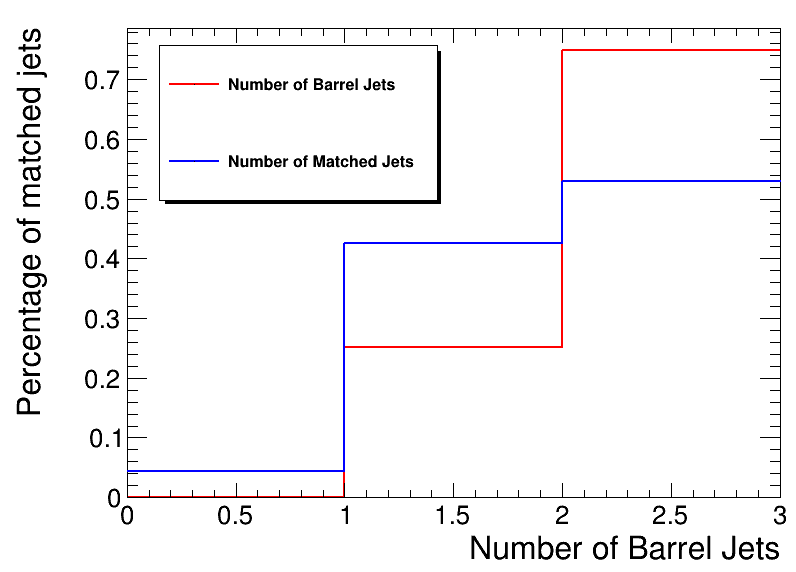

In [52]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.2,0.65,0.55,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
h['barrel'] = create_TH1D( barrel_jets_perllp_dict['m500ctau1000'], axis_title=['Number of Barrel Jets', 'Percentage of matched jets'], name='match_efficiency', binning=[3,0,3])
h['barrel'].SetLineColor(2)
h['matched'] = create_TH1D( matched_jets_perllp_dict['m500ctau1000'], axis_title=['Number of Matched Jets', 'events'], name='match_efficiency', binning=[3,0,3])
h['matched'].SetLineColor(4)
# c.SetLogy()
# h['match_efficiency2'].GetYaxis().SetRangeUser(0,1.0)
leg.AddEntry(h['barrel'],'Number of Barrel Jets')
leg.AddEntry(h['matched'],'Number of Matched Jets')

h['barrel'].DrawNormalized()
h['matched'].DrawNormalized('same')
leg.Draw()
c.Draw()
c.SaveAs("../plots/barrel_matched.pdf")

# Number of Rechits

In [12]:
T=T1000

energy_cut = 1.0
#     n_rechits = np.array( [x if len(x) else -1 for x in T['jet_n_rechits']]) 
n_rechits = [] #n_rechits of matched and barrel jets
n_rechits_qcd = [] #n_rechits of matched and barrel jets
n_rechits_T1000 = [] #n_rechits of matched and barrel jets
n_rechits_T30 = [] #n_rechits of matched and barrel jets

n_rechits_llpdecay = [] # rechits and the corresponding LLP decay length

gLLP_decay_radius = np.sqrt(np.square(T['gLLP_decay_vertex_x'])+np.square(T['gLLP_decay_vertex_y'])) # (events, 2) 2LLP
gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']
rechits_E =  T['jet_rechits_E']

# matched_jets.shape = (events,4), logical whether the jet is matched and hit barrel
matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index == 666))
gLLP_daughter_match_jet_index = gLLP_daughter_match_jet_index[matched_jets]


for i in range(len(T['gLLP_daughter_match_jet_index'])): #loop through each event
    for j in range(4): #loop through each gen jet
        index = T['gLLP_daughter_match_jet_index'][i][j]
        if not index == 666 and matched_jets[i][j]:
            rechits = rechits_E[i][index]
            rechits = np.count_nonzero(rechits >= energy_cut)
            if j <= 1:
                llpid = 0
            else:
                llpid = 1
            n_rechits.append(rechits)
            n_rechits_llpdecay.append([rechits, gLLP_decay_radius[i,llpid]])
assert(len(n_rechits) == len(gLLP_daughter_match_jet_index))
n_rechits_llpdecay = np.array(n_rechits_llpdecay)
print(n_rechits_llpdecay.shape)

#QCD
# rechits_E_qcd =  QCD['jet_rechits_E']
# for i in range(len(rechits_E_qcd)): #loop through each event
#     for j in range(len(rechits_E_qcd[i])): #loop through each jet
#         rechits = rechits_E_qcd[i][j]
#         rechits = np.count_nonzero(rechits >= energy_cut)
#         n_rechits_qcd.append(rechits)
        
        
rechits_E_T1000 =  T1000['jet_rechits_E']
for i in range(len(rechits_E_T1000)): #loop through each event
    for j in range(len(rechits_E_T1000[i])): #loop through each jet
        rechits = rechits_E_T1000[i][j]
        rechits = np.count_nonzero(rechits >= energy_cut)
        n_rechits_T1000.append(rechits)
        
rechits_E_T30 =  T30['jet_rechits_E']
for i in range(len(rechits_E_T30)): #loop through each event
    for j in range(len(rechits_E_T30[i])): #loop through each jet
        rechits = rechits_E_T30[i][j]
        rechits = np.count_nonzero(rechits >= energy_cut)
        n_rechits_T30.append(rechits)


(25250, 2)
